#  Chapter 1 DataCleaning and Exploratory Data Analysis

This first session deals with data cleaning, EDA and builing a simplistic model that can be used for predicting the sale price of houses in Ames, IOWA. Here we try to understand the dataset and get familiar with the methodology for developing an efficient model.

The next session contains a report that contains  the detailed analysis, interpretation, and information for the models. We will do a cross-validation and data splitting where the original data set is split into two data sets: the training set and the validation set. 



## The Data
There are two data sets included in the data folder: `Ames_Housing_Price_Data.csv` and `Ames_Real_Estate_Data.csv`.

The `Ames_Housing_Price_Data.csv` set contains $81$ data columns, including the key feature **SalePrice** which will be used as the target of the predictive/descriptive modeling. **PID** refers to the land parcel ID, which can merged on the *MapRefNo* column of the **Ames Accessor Data** (`Ames_Real_Estate_Data.csv`) to find the property address. Using a free service, such as **geopy**, we can find the long-lat coordinates of the houses.

The columns of the data are mostly attributes associated with the land and the houses. There are size related attributes, quality and condition attributes, house attachment attributes, etc.

To establish a foundation for your team's data analytics, we offer some insights on the house sizes vs. prices.

## Outliers

The instructors' notes state:

> **Five observations** that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these
points). Three of them are true **outliers** (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced
relatively appropriately). I would **recommend removing any houses with more than
3700 square feet** from the data set (which eliminates these five unusual observations)
before assigning it to students.

To apply a more "rigorous" approach, outlier detection is conducted with a so-called Isolation Forest.

In [1]:
# Import the datasets and the libraries
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import csv
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statistics as stats
realEstate = pd.read_csv("Ames_Real_Estate_Data.csv")
realEstate = realEstate[['MapRefNo','Prop_Addr','MA_Zip1']]
geocode_data =pd.read_csv("geocode_data.csv")

#Linear Models
from sklearn.linear_model import Lasso, ElasticNet


#Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge


#Gradient Boosting Machines
from sklearn.ensemble import GradientBoostingRegressor

#Random Forest
from sklearn.ensemble import RandomForestRegressor

#Support Vector Machines
from sklearn import svm

#Linear Regression
from sklearn import linear_model

#Make Pipeline
from sklearn.pipeline import make_pipeline

#Robust Scaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split, KFold, cross_val_score


housing = pd.read_csv('Ames_HousePrice.csv', index_col=0)
housing = housing[housing.GrLivArea<3700]
from scipy import stats
housing.head()

/var/folders/04/cszrdrg50q9gqrdnh622flsh0000gn/T/ipykernel_59710/4081282890.py:14: DtypeWarning: Columns (36,40,81,87) have mixed types. Specify dtype option on import or set low_memory=False.
  realEstate = pd.read_csv("Ames_Real_Estate_Data.csv")


,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1,126000,909176150,856,30,RL,NaN,7890,Pave,NaN,Reg,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
2,139500,905476230,1049,120,RL,42.0,4235,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal
3,124900,911128020,1001,30,C (all),60.0,6060,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal
4,114000,535377150,1039,70,RL,80.0,8146,Pave,NaN,Reg,...,111,0,NaN,NaN,NaN,0,5,2009,WD,Normal
5,227000,534177230,1665,60,RL,70.0,8400,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal


In [2]:
year = housing.groupby("YrSold").mean()
#plt.scatter(year[['GrLivArea']], year["SalePrice"])
year
#list(map(lambda x,y: x/y, housing.groupby("YrSold")["SalePrice"].mean(), housing.groupby("YrSold")["GrLivArea"].mean() ))


,SalePrice,PID,GrLivArea,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold
YrSold,,,,,,,,,,,,,,,,,,,,,
2006,176649.310078,7.116811e+08,1489.604651,61.870155,68.212617,10084.932171,6.009690,5.511628,1969.501938,1980.207364,...,1.744186,463.364341,97.420543,48.796512,22.567829,1.439922,16.883721,3.812016,24.660853,6.408915
2007,178072.399666,7.140830e+08,1474.677258,54.841137,69.229979,10381.270903,6.006689,5.653846,1970.451505,1984.202341,...,1.743719,469.944724,91.804348,45.754181,24.675585,1.673913,17.280936,2.677258,62.946488,6.357860
2008,177980.802842,7.266982e+08,1485.761989,59.822380,67.508696,10075.685613,6.094139,5.710480,1969.126110,1984.772647,...,1.719361,457.037300,91.028419,47.998224,21.838366,3.344583,16.440497,1.278863,52.326821,6.293073
2009,180387.644444,7.022485e+08,1493.345299,53.974359,68.868644,10005.213675,6.121368,5.593162,1972.133333,1985.095726,...,1.820513,483.817094,98.842735,44.979487,22.205128,4.222222,14.668376,0.000000,27.982906,6.586325
2010,173971.666667,7.229245e+08,1462.180952,59.460317,68.246269,9726.584127,5.933333,5.606349,1969.971429,1984.231746,...,1.666667,449.679365,103.628571,38.717460,26.053968,1.212698,15.600000,0.000000,93.746032,4.273016


In [3]:
housing["Street"].value_counts()

Pave    2567
Grvl      10
Name: Street, dtype: int64

In [4]:
housing.isna().sum()

SalePrice        0
PID              0
GrLivArea        0
MSSubClass       0
MSZoning         0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 81, dtype: int64

In [5]:
housing.Condition1

1      Norm
2      Norm
3      Norm
4      Norm
5      Norm
       ... 
759    Norm
760    Norm
761    Norm
762    Norm
763    Norm
Name: Condition1, Length: 2577, dtype: object

In [6]:
geocode_data.head()

,Unnamed: 0,PID,lat,long,dist,income,gcode
0,1971,535180070,42.042894,-93.612641,3.326988,52375.0,"210, 21st Street, Broadmoor, Ames, Story Count..."
1,1357,908102040,42.020564,-93.678868,2.760245,33311.0,"234, South Dakota Avenue, Ames, Story County, ..."
2,357,906380170,42.024622,-93.691352,3.713174,60833.0,"5327, Durant Street, Sunset Ridge, Ames, Story..."
3,65,909250060,42.019084,-93.646893,0.847709,20878.0,"2320, Knapp Street, Union Drive, Ames, Story C..."
4,1094,534276180,42.042544,-93.621391,2.721892,61991.0,"2027, Ferndale Avenue, Melrose Park, Ames, Sto..."


In [7]:
housing = pd.merge(housing, geocode_data.iloc[:,1:6], how='left', left_on='PID', right_on ="PID")
housing.isna().sum()

SalePrice          0
PID                0
GrLivArea          0
MSSubClass         0
MSZoning           0
                ... 
SaleCondition      0
lat               99
long              99
dist              99
income           184
Length: 85, dtype: int64

In [8]:
#housing["exp_OverallQual"]= housing["OverallQual"].apply(lambda x: np.exp(x))
qual_related = housing.filter(regex='Qual$|Cond$').fillna("TA")

qual_related

,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,KitchenQual,GarageQual,GarageCond
0,6,6,TA,TA,TA,TA,TA,TA,TA
1,5,5,Gd,TA,Gd,TA,Gd,TA,TA
2,5,9,Gd,TA,TA,TA,Gd,TA,Po
3,4,8,Gd,Gd,Fa,TA,TA,TA,TA
4,8,6,Gd,TA,Gd,TA,Gd,TA,TA
...,...,...,...,...,...,...,...,...,...
2572,6,6,TA,TA,TA,TA,Fa,Fa,Po
2573,3,5,TA,TA,TA,TA,TA,TA,TA
2574,5,6,TA,TA,TA,TA,TA,TA,TA
2575,7,5,Gd,TA,Gd,TA,Gd,TA,TA


AxesSubplot(0.125,0.125;0.775x0.755)


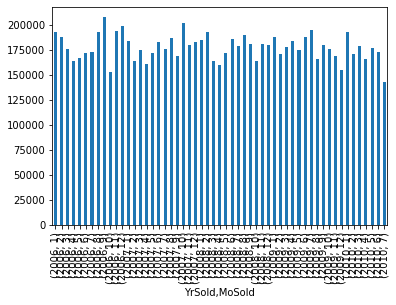

In [9]:
print(housing.groupby(['YrSold','MoSold'])['SalePrice'].aggregate(np.mean).plot(kind='bar'
                                                                              
                                                                             ))

In [10]:
housing.SalePrice

0       126000
1       139500
2       124900
3       114000
4       227000
         ...  
2572    121000
2573    139600
2574    145000
2575    217500
2576    215000
Name: SalePrice, Length: 2577, dtype: int64

In [11]:
qual_related.GarageCond.value_counts()

TA    2482
Fa      67
Gd      14
Po      11
Ex       3
Name: GarageCond, dtype: int64

In [12]:
# Fill missing values vith TA
qual_related.fillna("TA", inplace=True)
def Rating(t):
    if t =="Ex": return  7
    elif t == "Gd": return 5
    elif t == "TA": return 3
    elif t == "Fa": return 2.5
    elif t == "Po": return 1
    else: return 0
for ele in qual_related.iloc[:,2:]:
    
    housing[ele]=qual_related[ele].map(Rating)
    qual_related[ele]=housing[ele]
housing

,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,lat,long,dist,income
0,126000,909176150,856,30,RL,NaN,7890,Pave,NaN,Reg,...,NaN,0,3,2010,WD,Normal,42.018564,-93.651619,0.998896,NaN
1,139500,905476230,1049,120,RL,42.0,4235,Pave,NaN,Reg,...,NaN,0,2,2009,WD,Normal,42.024855,-93.663671,1.433537,21333.0
2,124900,911128020,1001,30,C (all),60.0,6060,Pave,NaN,Reg,...,NaN,0,11,2007,WD,Normal,NaN,NaN,NaN,NaN
3,114000,535377150,1039,70,RL,80.0,8146,Pave,NaN,Reg,...,NaN,0,5,2009,WD,Normal,42.037391,-93.612207,3.072689,52375.0
4,227000,534177230,1665,60,RL,70.0,8400,Pave,NaN,Reg,...,NaN,0,11,2009,WD,Normal,42.044554,-93.631818,2.326978,61991.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,121000,903205040,952,30,RL,NaN,8854,Pave,NaN,Reg,...,NaN,0,5,2009,WD,Normal,42.032102,-93.626373,1.768156,37028.0
2573,139600,905402060,1733,20,RL,NaN,13680,Pave,NaN,IR1,...,NaN,0,6,2009,WD,Normal,42.027669,-93.666138,1.626168,21333.0
2574,145000,909275030,2002,90,RH,82.0,6270,Pave,NaN,Reg,...,NaN,0,8,2007,WD,Normal,42.020129,-93.643832,0.763415,20878.0
2575,217500,907192040,1842,60,RL,NaN,8826,Pave,NaN,Reg,...,NaN,0,7,2007,WD,Normal,42.016802,-93.689748,3.739425,33311.0


In [13]:
housing.isna().sum()

SalePrice          0
PID                0
GrLivArea          0
MSSubClass         0
MSZoning           0
                ... 
SaleCondition      0
lat               99
long              99
dist              99
income           184
Length: 85, dtype: int64

In [14]:
housing.SalePrice

0       126000
1       139500
2       124900
3       114000
4       227000
         ...  
2572    121000
2573    139600
2574    145000
2575    217500
2576    215000
Name: SalePrice, Length: 2577, dtype: int64

In [15]:
# Fill missing values vith TA

def yearidx(t):
    if t ==2006: return  1.186
    elif t == 2007: return 1.208
    elif t == 2008: return 1.198
    elif t == 2009: return 1.208
    elif t == 2010: return 1.19
    else: return 1.2

    
housing["GrLivArea_year"]=housing["YrSold"].map(yearidx)*housing["GrLivArea"]
housing

,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,lat,long,dist,income,GrLivArea_year
0,126000,909176150,856,30,RL,NaN,7890,Pave,NaN,Reg,...,0,3,2010,WD,Normal,42.018564,-93.651619,0.998896,NaN,1018.640
1,139500,905476230,1049,120,RL,42.0,4235,Pave,NaN,Reg,...,0,2,2009,WD,Normal,42.024855,-93.663671,1.433537,21333.0,1267.192
2,124900,911128020,1001,30,C (all),60.0,6060,Pave,NaN,Reg,...,0,11,2007,WD,Normal,NaN,NaN,NaN,NaN,1209.208
3,114000,535377150,1039,70,RL,80.0,8146,Pave,NaN,Reg,...,0,5,2009,WD,Normal,42.037391,-93.612207,3.072689,52375.0,1255.112
4,227000,534177230,1665,60,RL,70.0,8400,Pave,NaN,Reg,...,0,11,2009,WD,Normal,42.044554,-93.631818,2.326978,61991.0,2011.320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,121000,903205040,952,30,RL,NaN,8854,Pave,NaN,Reg,...,0,5,2009,WD,Normal,42.032102,-93.626373,1.768156,37028.0,1150.016
2573,139600,905402060,1733,20,RL,NaN,13680,Pave,NaN,IR1,...,0,6,2009,WD,Normal,42.027669,-93.666138,1.626168,21333.0,2093.464
2574,145000,909275030,2002,90,RH,82.0,6270,Pave,NaN,Reg,...,0,8,2007,WD,Normal,42.020129,-93.643832,0.763415,20878.0,2418.416
2575,217500,907192040,1842,60,RL,NaN,8826,Pave,NaN,Reg,...,0,7,2007,WD,Normal,42.016802,-93.689748,3.739425,33311.0,2225.136


In [16]:
ele2=0
lst= []
for ele in housing["YrSold"]:
    lst.append(str(ele)+str(housing["MoSold"][ele2]))
    ele2=ele2+1
housing["YrMoSold"] = lst
yrmopr= housing.groupby(["YrMoSold"])[["SalePrice"]].mean()
yrmopr.columns = ["Price_by_yrmo"]
yrmopr.rename({"SalePrice":"Price_by_yrmo"}, inplace =True)    
housing = pd.merge(housing, yrmopr, how='left', left_on='YrMoSold', right_on = 'YrMoSold')
housing

,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,YrSold,SaleType,SaleCondition,lat,long,dist,income,GrLivArea_year,YrMoSold,Price_by_yrmo
0,126000,909176150,856,30,RL,NaN,7890,Pave,NaN,Reg,...,2010,WD,Normal,42.018564,-93.651619,0.998896,NaN,1018.640,20103,178828.413043
1,139500,905476230,1049,120,RL,42.0,4235,Pave,NaN,Reg,...,2009,WD,Normal,42.024855,-93.663671,1.433537,21333.0,1267.192,20092,171429.720000
2,124900,911128020,1001,30,C (all),60.0,6060,Pave,NaN,Reg,...,2007,WD,Normal,NaN,NaN,NaN,NaN,1209.208,200711,179679.806452
3,114000,535377150,1039,70,RL,80.0,8146,Pave,NaN,Reg,...,2009,WD,Normal,42.037391,-93.612207,3.072689,52375.0,1255.112,20095,174817.126984
4,227000,534177230,1665,60,RL,70.0,8400,Pave,NaN,Reg,...,2009,WD,Normal,42.044554,-93.631818,2.326978,61991.0,2011.320,200911,169511.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,121000,903205040,952,30,RL,NaN,8854,Pave,NaN,Reg,...,2009,WD,Normal,42.032102,-93.626373,1.768156,37028.0,1150.016,20095,174817.126984
2573,139600,905402060,1733,20,RL,NaN,13680,Pave,NaN,IR1,...,2009,WD,Normal,42.027669,-93.666138,1.626168,21333.0,2093.464,20096,188315.336735
2574,145000,909275030,2002,90,RH,82.0,6270,Pave,NaN,Reg,...,2007,WD,Normal,42.020129,-93.643832,0.763415,20878.0,2418.416,20078,187132.241935
2575,217500,907192040,1842,60,RL,NaN,8826,Pave,NaN,Reg,...,2007,WD,Normal,42.016802,-93.689748,3.739425,33311.0,2225.136,20077,175664.905263


In [17]:
housing

,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,YrSold,SaleType,SaleCondition,lat,long,dist,income,GrLivArea_year,YrMoSold,Price_by_yrmo
0,126000,909176150,856,30,RL,NaN,7890,Pave,NaN,Reg,...,2010,WD,Normal,42.018564,-93.651619,0.998896,NaN,1018.640,20103,178828.413043
1,139500,905476230,1049,120,RL,42.0,4235,Pave,NaN,Reg,...,2009,WD,Normal,42.024855,-93.663671,1.433537,21333.0,1267.192,20092,171429.720000
2,124900,911128020,1001,30,C (all),60.0,6060,Pave,NaN,Reg,...,2007,WD,Normal,NaN,NaN,NaN,NaN,1209.208,200711,179679.806452
3,114000,535377150,1039,70,RL,80.0,8146,Pave,NaN,Reg,...,2009,WD,Normal,42.037391,-93.612207,3.072689,52375.0,1255.112,20095,174817.126984
4,227000,534177230,1665,60,RL,70.0,8400,Pave,NaN,Reg,...,2009,WD,Normal,42.044554,-93.631818,2.326978,61991.0,2011.320,200911,169511.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,121000,903205040,952,30,RL,NaN,8854,Pave,NaN,Reg,...,2009,WD,Normal,42.032102,-93.626373,1.768156,37028.0,1150.016,20095,174817.126984
2573,139600,905402060,1733,20,RL,NaN,13680,Pave,NaN,IR1,...,2009,WD,Normal,42.027669,-93.666138,1.626168,21333.0,2093.464,20096,188315.336735
2574,145000,909275030,2002,90,RH,82.0,6270,Pave,NaN,Reg,...,2007,WD,Normal,42.020129,-93.643832,0.763415,20878.0,2418.416,20078,187132.241935
2575,217500,907192040,1842,60,RL,NaN,8826,Pave,NaN,Reg,...,2007,WD,Normal,42.016802,-93.689748,3.739425,33311.0,2225.136,20077,175664.905263


### UpSampling the Street labels

In [18]:
housing.Street.value_counts()
def Ratio(t):
    if t == 'Pave': return 1.0
   
    else: return 180.0
# the returned values must be integers   
ratios = housing['Street'].map(Ratio)
index_repeat = housing.index.repeat(ratios)
index_repeat = pd.Series(index_repeat, name='repeat')
index_repeat.shape

(4367,)

In [19]:
housing["Street"].value_counts()
housing["Street"] =housing["Street"].apply(lambda x: 1 if x=="Pave" else 0)
housing

,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,YrSold,SaleType,SaleCondition,lat,long,dist,income,GrLivArea_year,YrMoSold,Price_by_yrmo
0,126000,909176150,856,30,RL,NaN,7890,1,NaN,Reg,...,2010,WD,Normal,42.018564,-93.651619,0.998896,NaN,1018.640,20103,178828.413043
1,139500,905476230,1049,120,RL,42.0,4235,1,NaN,Reg,...,2009,WD,Normal,42.024855,-93.663671,1.433537,21333.0,1267.192,20092,171429.720000
2,124900,911128020,1001,30,C (all),60.0,6060,1,NaN,Reg,...,2007,WD,Normal,NaN,NaN,NaN,NaN,1209.208,200711,179679.806452
3,114000,535377150,1039,70,RL,80.0,8146,1,NaN,Reg,...,2009,WD,Normal,42.037391,-93.612207,3.072689,52375.0,1255.112,20095,174817.126984
4,227000,534177230,1665,60,RL,70.0,8400,1,NaN,Reg,...,2009,WD,Normal,42.044554,-93.631818,2.326978,61991.0,2011.320,200911,169511.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,121000,903205040,952,30,RL,NaN,8854,1,NaN,Reg,...,2009,WD,Normal,42.032102,-93.626373,1.768156,37028.0,1150.016,20095,174817.126984
2573,139600,905402060,1733,20,RL,NaN,13680,1,NaN,IR1,...,2009,WD,Normal,42.027669,-93.666138,1.626168,21333.0,2093.464,20096,188315.336735
2574,145000,909275030,2002,90,RH,82.0,6270,1,NaN,Reg,...,2007,WD,Normal,42.020129,-93.643832,0.763415,20878.0,2418.416,20078,187132.241935
2575,217500,907192040,1842,60,RL,NaN,8826,1,NaN,Reg,...,2007,WD,Normal,42.016802,-93.689748,3.739425,33311.0,2225.136,20077,175664.905263


housing = housing.loc[index_repeat].Street.value_counts()

In [20]:
housing = pd.merge(index_repeat, housing, how='left', left_on = "repeat", right_on=housing.index)

In [21]:
housing.SalePrice

0       126000
1       139500
2       124900
3       114000
4       227000
         ...  
4362    121000
4363    139600
4364    145000
4365    217500
4366    215000
Name: SalePrice, Length: 4367, dtype: int64

In [22]:
housing.isna().sum()

repeat               0
SalePrice            0
PID                  0
GrLivArea            0
MSSubClass           0
                  ... 
dist               994
income            1258
GrLivArea_year       0
YrMoSold             0
Price_by_yrmo        0
Length: 89, dtype: int64

In [23]:
housing.OverallQual

0       6
1       5
2       5
3       4
4       8
       ..
4362    6
4363    3
4364    5
4365    7
4366    8
Name: OverallQual, Length: 4367, dtype: int64

In [24]:
def Ratio2(t):
    if t =="Pave": return  20
    elif t == "Grvl": return 15
    else: return 1

ratios = housing['Alley'].map(Ratio2)
index_repeat = housing.index.repeat(ratios)
index_repeat = pd.Series(index_repeat, name='repeat1')
index_repeat
housing = pd.merge(index_repeat, housing, how='left', left_on = "repeat1", right_on=housing.index)
housing.shape


(7034, 90)

In [25]:
def fnd(t):
    if t =="PConc": return  1
    elif t == "CBlock": return 0
    else: return -0.5

housing['Foundation'] = housing['Foundation'].map(fnd)
    
    
       

In [26]:
housing.Alley.value_counts()

Grvl    1575
Pave    1260
Name: Alley, dtype: int64

In [27]:
def alley(t):
    if t =="Pave": return  1
    elif t == "Grvl": return 0
    else: return -0.1

housing['Alley'] = housing['Alley'].map(alley)
    
    
       

In [28]:
housing["GarageType"].value_counts()

Detchd     3298
Attchd     2370
2Types      228
BuiltIn     190
CarPort     188
Basment      27
Name: GarageType, dtype: int64

In [29]:
def grg(t):
    if t ==("Attchd" or "Builtin") : return  1
    else: return 0
    -0.5

housing['GarageType'] = housing['GarageType'].map(grg)

In [30]:
def scond(t):
    if t ==("Partial") :
        return  1
    elif t == "Normal":
        return 0
    else: return -1

housing['SaleCondition'] = housing['SaleCondition'].map(scond)

In [31]:
housing.SalePrice

0       126000
1       139500
2       124900
3       114000
4       227000
         ...  
7029    121000
7030    139600
7031    145000
7032    217500
7033    215000
Name: SalePrice, Length: 7034, dtype: int64

In [32]:
def stype(t):
    if t ==("CWD") :
        return  2
    elif t ==("New") :
        return  1
    elif t == "Con":
        return 0.7
    if t ==("ConLD") :
        return  -1
    else: return 0

housing['SaleType'] = housing['SaleType'].map(stype)

In [33]:
housing["MasVnrType"] =np.where(housing["MasVnrType"]==("BrkCmn" or "Stone"),1,0)

In [34]:
housing["RoofStyle"] = np.where(housing["RoofStyle"] == "Hip",1,0)

In [35]:
# Checking unique PID #s
uni = housing.PID.unique()
uni.shape

(2576,)

In [36]:
housing.isna().sum()

repeat1              0
repeat               0
SalePrice            0
PID                  0
GrLivArea            0
                  ... 
dist              1130
income            1492
GrLivArea_year       0
YrMoSold             0
Price_by_yrmo        0
Length: 90, dtype: int64

In [37]:
housing.shape

(7034, 90)

<AxesSubplot:title={'center':'SalePrice'}, xlabel='Neighborhood'>

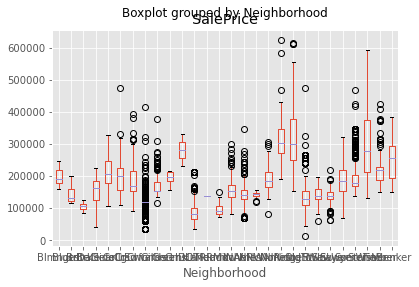

In [38]:
# How does the price vary by neighbourhood
plt.style.use('ggplot')



housing.boxplot(column ='SalePrice', by = 'Neighborhood')

In [39]:
# merging 2.5Unf values into 1Story
housing['HouseStyle'].replace('2.5Unf', '1Story', inplace=True)
# merging 2.5Fin to 2Story
housing['HouseStyle'].replace('2.5Fin', '2Story', inplace=True)
# merging 1.5Unf values into 1.5Fin
housing['HouseStyle'].replace('1.5Unf', '1.5Fin', inplace=True)

In [40]:
housing.HouseStyle.value_counts()

1Story    3165
2Story    2110
1.5Fin    1359
SFoyer     263
SLvl       137
Name: HouseStyle, dtype: int64

### Encoding and Dummyfication

In [41]:
# get the averge price by neighborhood
dummy = housing.groupby(["Neighborhood"])[["SalePrice"]].mean()
dummy.rename(columns = {"SalePrice":"Price_by_hood"}, inplace =True)
dummy

,Price_by_hood
Neighborhood,
Blmngtn,196237.173913
Blueste,143590.000000
BrDale,106094.827586
BrkSide,152798.333333
ClearCr,213980.800000
CollgCr,198133.169492
Crawfor,184939.409396
Edwards,117037.821586
Gilbert,169852.226708


In [42]:

housing = pd.merge(housing, dummy, how='left', on=['Neighborhood', 'Neighborhood'])
housing

,repeat1,repeat,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,...,SaleType,SaleCondition,lat,long,dist,income,GrLivArea_year,YrMoSold,Price_by_yrmo,Price_by_hood
0,0,0,126000,909176150,856,30,RL,NaN,7890,1,...,0.0,0,42.018564,-93.651619,0.998896,NaN,1018.640,20103,178828.413043,141548.938053
1,1,1,139500,905476230,1049,120,RL,42.0,4235,1,...,0.0,0,42.024855,-93.663671,1.433537,21333.0,1267.192,20092,171429.720000,117037.821586
2,2,2,124900,911128020,1001,30,C (all),60.0,6060,1,...,0.0,0,NaN,NaN,NaN,NaN,1209.208,200711,179679.806452,86192.145849
3,3,3,114000,535377150,1039,70,RL,80.0,8146,1,...,0.0,0,42.037391,-93.612207,3.072689,52375.0,1255.112,20095,174817.126984,132799.233062
4,4,4,227000,534177230,1665,60,RL,70.0,8400,1,...,0.0,0,42.044554,-93.631818,2.326978,61991.0,2011.320,200911,169511.428571,190372.398374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7029,4362,2572,121000,903205040,952,30,RL,NaN,8854,1,...,0.0,0,42.032102,-93.626373,1.768156,37028.0,1150.016,20095,174817.126984,152798.333333
7030,4363,2573,139600,905402060,1733,20,RL,NaN,13680,1,...,0.0,0,42.027669,-93.666138,1.626168,21333.0,2093.464,20096,188315.336735,117037.821586
7031,4364,2574,145000,909275030,2002,90,RH,82.0,6270,1,...,0.0,0,42.020129,-93.643832,0.763415,20878.0,2418.416,20078,187132.241935,184939.409396
7032,4365,2575,217500,907192040,1842,60,RL,NaN,8826,1,...,0.0,0,42.016802,-93.689748,3.739425,33311.0,2225.136,20077,175664.905263,198133.169492


In [43]:
# get the averge price by neighborhood
dummy2 = housing.groupby(["YrSold"])[["SalePrice"]].mean()
dummy2.rename(columns = {"SalePrice":"Price_by_yr"}, inplace =True)
dummy2

,Price_by_yr
YrSold,
2006,145412.995050
2007,164561.190789
2008,146989.860215
2009,150867.646971
2010,148515.221643


In [44]:

housing = pd.merge(housing, dummy2, how='left', on=['YrSold', 'YrSold'])
housing

,repeat1,repeat,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,...,SaleCondition,lat,long,dist,income,GrLivArea_year,YrMoSold,Price_by_yrmo,Price_by_hood,Price_by_yr
0,0,0,126000,909176150,856,30,RL,NaN,7890,1,...,0,42.018564,-93.651619,0.998896,NaN,1018.640,20103,178828.413043,141548.938053,148515.221643
1,1,1,139500,905476230,1049,120,RL,42.0,4235,1,...,0,42.024855,-93.663671,1.433537,21333.0,1267.192,20092,171429.720000,117037.821586,150867.646971
2,2,2,124900,911128020,1001,30,C (all),60.0,6060,1,...,0,NaN,NaN,NaN,NaN,1209.208,200711,179679.806452,86192.145849,164561.190789
3,3,3,114000,535377150,1039,70,RL,80.0,8146,1,...,0,42.037391,-93.612207,3.072689,52375.0,1255.112,20095,174817.126984,132799.233062,150867.646971
4,4,4,227000,534177230,1665,60,RL,70.0,8400,1,...,0,42.044554,-93.631818,2.326978,61991.0,2011.320,200911,169511.428571,190372.398374,150867.646971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7029,4362,2572,121000,903205040,952,30,RL,NaN,8854,1,...,0,42.032102,-93.626373,1.768156,37028.0,1150.016,20095,174817.126984,152798.333333,150867.646971
7030,4363,2573,139600,905402060,1733,20,RL,NaN,13680,1,...,0,42.027669,-93.666138,1.626168,21333.0,2093.464,20096,188315.336735,117037.821586,150867.646971
7031,4364,2574,145000,909275030,2002,90,RH,82.0,6270,1,...,0,42.020129,-93.643832,0.763415,20878.0,2418.416,20078,187132.241935,184939.409396,164561.190789
7032,4365,2575,217500,907192040,1842,60,RL,NaN,8826,1,...,0,42.016802,-93.689748,3.739425,33311.0,2225.136,20077,175664.905263,198133.169492,164561.190789


In [45]:
# get the averge price by neighborhood
dummy2 = housing.groupby(["MoSold"])[["SalePrice"]].mean()
dummy2.rename(columns = {"SalePrice":"Price_by_month"}, inplace =True)

housing = pd.merge(housing, dummy2, how='left', on=['MoSold','MoSold'])
housing


,repeat1,repeat,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,...,lat,long,dist,income,GrLivArea_year,YrMoSold,Price_by_yrmo,Price_by_hood,Price_by_yr,Price_by_month
0,0,0,126000,909176150,856,30,RL,NaN,7890,1,...,42.018564,-93.651619,0.998896,NaN,1018.640,20103,178828.413043,141548.938053,148515.221643,133047.651475
1,1,1,139500,905476230,1049,120,RL,42.0,4235,1,...,42.024855,-93.663671,1.433537,21333.0,1267.192,20092,171429.720000,117037.821586,150867.646971,163437.446746
2,2,2,124900,911128020,1001,30,C (all),60.0,6060,1,...,NaN,NaN,NaN,NaN,1209.208,200711,179679.806452,86192.145849,164561.190789,170739.569565
3,3,3,114000,535377150,1039,70,RL,80.0,8146,1,...,42.037391,-93.612207,3.072689,52375.0,1255.112,20095,174817.126984,132799.233062,150867.646971,150102.980769
4,4,4,227000,534177230,1665,60,RL,70.0,8400,1,...,42.044554,-93.631818,2.326978,61991.0,2011.320,200911,169511.428571,190372.398374,150867.646971,170739.569565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7029,4362,2572,121000,903205040,952,30,RL,NaN,8854,1,...,42.032102,-93.626373,1.768156,37028.0,1150.016,20095,174817.126984,152798.333333,150867.646971,150102.980769
7030,4363,2573,139600,905402060,1733,20,RL,NaN,13680,1,...,42.027669,-93.666138,1.626168,21333.0,2093.464,20096,188315.336735,117037.821586,150867.646971,149444.281879
7031,4364,2574,145000,909275030,2002,90,RH,82.0,6270,1,...,42.020129,-93.643832,0.763415,20878.0,2418.416,20078,187132.241935,184939.409396,164561.190789,161918.266839
7032,4365,2575,217500,907192040,1842,60,RL,NaN,8826,1,...,42.016802,-93.689748,3.739425,33311.0,2225.136,20077,175664.905263,198133.169492,164561.190789,149674.039216


In [46]:
housing.isna().sum()

repeat1           0
repeat            0
SalePrice         0
PID               0
GrLivArea         0
                 ..
YrMoSold          0
Price_by_yrmo     0
Price_by_hood     0
Price_by_yr       0
Price_by_month    0
Length: 93, dtype: int64

In [47]:
housing.SaleType.value_counts()

 0.0    6360
-1.0     433
 1.0     211
 0.7      19
 2.0      11
Name: SaleType, dtype: int64

In [48]:
housing.columns

Index(['repeat1', 'repeat', 'SalePrice', 'PID', 'GrLivArea', 'MSSubClass',
       'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual

In [49]:

# We trim the outliers from the list
#housing = housing
#leng = len(housing)
#print(leng)
#housing["Gradient"] = (housing.SalePrice-15000)/(housing.GrLivArea)

#housing=housing.sort_values(by="Gradient")[(housing.sort_values(by="Gradient")["Gradient"]>30) & (housing.sort_values(by="Gradient")["Gradient"]<220)]
#housing["Gradient2"] = (housing.SalePrice)/(housing.GrLivArea-1600.01) 
#housing=housing.sort_values(by="Gradient2")[ (housing.sort_values(by="Gradient2")["Gradient2"]>250)|(housing.sort_values(by="Gradient2")["Gradient2"]<0)]
#housing["Gradient3"] = (housing.SalePrice -100000)/(housing.TotalBsmtSF +1) 
#housing=housing.sort_values(by="Gradient3")[ (housing.sort_values(by="Gradient3")["Gradient3"]<200)]
#housing["Gradient4"] = (housing.SalePrice)/(housing.TotalBsmtSF-1200.01) 
#housing=housing.sort_values(by="Gradient4")[ (housing.sort_values(by="Gradient4")["Gradient4"]>300000/1300)|(housing.sort_values(by="Gradient4")["Gradient4"]<0)]

#housing
#leng2 = len(housing)
#outlier_pct = 100*(leng-leng2)/leng
#outlier_pct


In [50]:
housing.PavedDrive = np.where(housing.PavedDrive=="N", 0,1)
housing.CentralAir = np.where(housing.CentralAir=="N", 0,1)

### Fixing Missing Values

In [51]:
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_pct = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_pct], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns.sort_values(by= "Missing Values")[mis_val_table_ren_columns["Missing Values"]>10] 
    

/var/folders/04/cszrdrg50q9gqrdnh622flsh0000gn/T/ipykernel_59710/2694707503.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mis_val_table_ren_columns.sort_values(by= "Missing Values")[mis_val_table_ren_columns["Missing Values"]>10]


<AxesSubplot:>

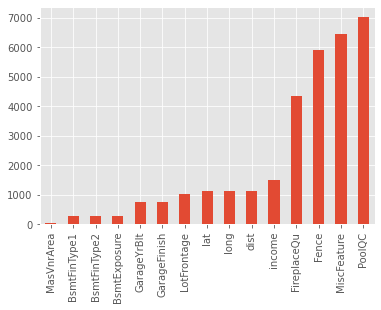

In [52]:
missing_values_table(housing)["Missing Values"].plot.bar()

In [53]:
housing=housing.drop(["MiscFeature"], axis=1)

In [54]:
housing[housing.columns[housing.isnull().any()]]

,LotFrontage,MasVnrArea,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Electrical,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PoolQC,Fence,lat,long,dist,income
0,NaN,0.0,No,Rec,238.0,Unf,0.0,618.0,856.0,SBrkr,...,1939.0,Unf,2.0,399.0,NaN,NaN,42.018564,-93.651619,0.998896,NaN
1,42.0,149.0,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0,SBrkr,...,1984.0,Fin,1.0,266.0,NaN,NaN,42.024855,-93.663671,1.433537,21333.0
2,60.0,0.0,No,ALQ,737.0,Unf,0.0,100.0,837.0,SBrkr,...,1930.0,Unf,1.0,216.0,NaN,NaN,NaN,NaN,NaN,NaN
3,80.0,0.0,No,Unf,0.0,Unf,0.0,405.0,405.0,SBrkr,...,1940.0,Unf,1.0,281.0,NaN,NaN,42.037391,-93.612207,3.072689,52375.0
4,70.0,0.0,No,GLQ,643.0,Unf,0.0,167.0,810.0,SBrkr,...,2001.0,Fin,2.0,528.0,NaN,NaN,42.044554,-93.631818,2.326978,61991.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7029,NaN,0.0,No,Unf,0.0,Unf,0.0,952.0,952.0,FuseF,...,1916.0,Unf,1.0,192.0,NaN,NaN,42.032102,-93.626373,1.768156,37028.0
7030,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,FuseA,...,1955.0,Unf,2.0,452.0,NaN,NaN,42.027669,-93.666138,1.626168,21333.0
7031,82.0,0.0,No,BLQ,284.0,Unf,0.0,717.0,1001.0,FuseA,...,1949.0,Unf,3.0,871.0,NaN,NaN,42.020129,-93.643832,0.763415,20878.0
7032,NaN,144.0,No,GLQ,841.0,Unf,0.0,144.0,985.0,SBrkr,...,2000.0,Fin,2.0,486.0,NaN,NaN,42.016802,-93.689748,3.739425,33311.0


### "Proximity to various Conditions"

The columns *Condition 1* and *Condition 2* have the same realizations and can be regarded as "tags" given to a house indicating the nearby presence of a) a major street, b) a railroad, or c) a park.

The default tag "Norm" (implying no "condition") is given to 86% of the houses 

In [55]:
housing["Condition1"] = housing["Condition1"].apply(lambda x: 0 if x =="Norm" else 1)
housing["Condition2"] = housing["Condition2"].apply(lambda x: 0 if x =="Norm" else 1)


In [56]:
#changing the NA values which aren't NAs to different values to work better with the data set
medl = housing.LotFrontage.median()
medm = housing.MasVnrArea.median()
housing.Alley = housing.Alley.fillna("No Alley Access")
housing.LotFrontage = housing.LotFrontage.fillna(medl)
housing.MasVnrArea = housing.MasVnrArea.fillna(medm)
housing.MasVnrType = housing.MasVnrType.fillna('None')
housing.BsmtQual = housing.BsmtQual.fillna("No Basement")

In [57]:

housing.PoolQC = housing.PoolQC.fillna(0)
housing.PoolQC=np.where(housing.PoolQC==0, 0,1)

In [58]:
# Fill the NA with the right values
housing.BsmtCond = housing.BsmtCond.fillna("No Basement")
housing.BsmtExposure = housing.BsmtExposure.fillna("No Basement")
housing.BsmtFinType1 = housing.BsmtFinType1.fillna("No Basement")
housing.BsmtFinType2 = housing.BsmtFinType2.fillna("No Basement")
housing.FireplaceQu = housing.FireplaceQu.fillna("No Fireplace")
housing.GarageType = housing.GarageType.fillna("No Garage")
housing.GarageFinish = housing.GarageFinish.fillna("No Garage")
housing.GarageQual = housing.GarageQual.fillna("No Garage")
housing.GarageCond = housing.GarageCond.fillna("No Garage")
housing.Fence = housing.Fence.fillna("No Fence")
housing.Electrical = housing.Electrical.fillna("None")


In [59]:
def ext(t):
    if t in  ['PreCast',  'ImStucc', 'CemntBd']:
        return 1
    elif t in ['AsphShn', 'AsbShng', 'CBlock']:
        return -1
    else: 
        return 0
housing['Exterior1st'] = housing['Exterior1st'].map(ext)
housing['Exterior2nd'] = housing['Exterior2nd'].map(ext)

for i in range(len(housing["Exterior1st"])):
    if housing["Exterior1st"][i] in  ['PreCast',  'ImStucc', 'CemntBd']:
        housing["Exterior1st"][i] =1
    elif housing["Exterior1st"][i] in ['AsphShn', 'AsbShng', 'CBlock']:
        housing["Exterior1st"][i] =-1
    else: 
        housing["Exterior1st"][i] =0
for i in range(len(housing["Exterior2nd"])):
    if housing["Exterior1st"][i] in  ['PreCast',  'ImStucc', 'CemntBd']:
        housing["Exterior1st"][i] =1
    elif housing["Exterior1st"][i] in ['AsphShn', 'AsbShng', 'CBlock']:
        housing["Exterior1st"][i] =-1
    else: 
        housing["Exterior1st"][i] =0    


In [60]:
# Unify the two townhouse types into one.
housing["BldgType"] = housing["BldgType"].apply(
    lambda x: "Twnhs" if x in ("TwnhsE", "TwnhsI") else x
)
# Unify the two kinds of 2-family homes.
housing["BldgType"] = housing["BldgType"].apply(
    lambda x: "2Fam" if x in ("2FmCon", "Duplx") else x
)

In [61]:

med1 = housing.BsmtFinSF1.median()
med2 = housing.BsmtFinSF2.median()
medf = housing.BsmtUnfSF.median()
medt = housing.TotalBsmtSF.median()
meda = housing.GarageArea.median()
medlon =housing.long.median()
medlat = housing.lat.median()
medist = housing.dist.median()
medinc = housing.income.median()

housing.BsmtFinSF1 = housing.BsmtFinSF1.fillna(med1)
housing.BsmtFinSF2 = housing.BsmtFinSF2.fillna(med2)
housing.BsmtUnfSF = housing.BsmtUnfSF.fillna(medf)
housing.TotalBsmtSF = housing.TotalBsmtSF.fillna(medt)
housing.GarageArea = housing.GarageArea.fillna(meda)
housing.long = housing.long.fillna(medlon)
housing.lat = housing.lat.fillna(medlat)
housing.dist = housing.dist.fillna(medist)
housing.income = housing.income.fillna(medinc)

housing.BsmtFullBath = housing.BsmtFullBath.fillna(0.0)
housing.BsmtHalfBath = housing.BsmtHalfBath.fillna(0.0)
housing.GarageCars = housing.GarageCars.fillna(0.0)

housing.GarageYrBlt = np.where(housing.GarageYrBlt.notnull(),housing.GarageYrBlt, housing.YearBuilt)

housing.TotalBsmtSF = np.where(housing.TotalBsmtSF<20,800, housing.TotalBsmtSF)
housing.BsmtFinSF1 = np.where(housing.BsmtFinSF1<20,800, housing.BsmtFinSF1)


In [62]:
# We covert the year to age and take the squareroot to normalise the values
housing.YearBuilt = np.sqrt(2010 - housing.YearBuilt)
housing.GarageYrBlt = np.sqrt(2010 - housing.GarageYrBlt)
housing.YrSold = np.sqrt(2010 -housing.YrSold)
housing.YearRemodAdd = np.sqrt(2010 -housing.YearRemodAdd)

In [63]:
housing.YearBuilt

0        8.426150
1        5.099020
2        8.944272
3       10.488088
4        3.000000
          ...    
7029     9.695360
7030     7.416198
7031     7.810250
7032     3.162278
7033     4.123106
Name: YearBuilt, Length: 7034, dtype: float64

In [64]:
# Creation of new column combining full and half bathrooms into one
bathrm = (housing['FullBath'] + housing['BsmtFullBath'] +
(housing['HalfBath']*0.5) + (housing['BsmtHalfBath']*0.5))
housing['bathrm_cnt'] = bathrm

# Creation of new column combining deck/porch-related sq footage into one
patioSF = (housing['WoodDeckSF'] + housing['OpenPorchSF']+ housing['EnclosedPorch'] + 
           housing['3SsnPorch'] + housing['ScreenPorch'])
housing['patioSF'] = patioSF

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


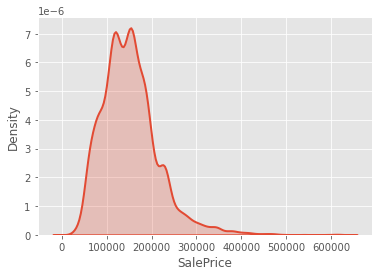

In [65]:
sns.distplot(housing.SalePrice, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2})
plt.show()

In [66]:
housing["SalePrice"].mean()

151798.31305089564

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,  16.,   1.,  21.,   0.,   2.,  15.,  19., 199., 206.,  34.,
         42., 420.,  52., 295., 170., 474., 553., 422., 409., 536., 747.,
        533., 536., 304., 213., 346., 107., 120.,  66.,  52.,  48.,  26.,
         21.,   9.,   8.,   2.,   3.,   6.]),
 array([ 9.45641889,  9.53420069,  9.61198248,  9.68976427,  9.76754607,
         9.84532786,  9.92310965, 10.00089144, 10.07867324, 10.15645503,
        10.23423682, 10.31201861, 10.38980041, 10.4675822 , 10.54536399,
        10.62314578, 10.70092758, 10.77870937, 10.85649116, 10.93427296,
        11.01205475, 11.08983654, 11.16761833, 11.24540013, 11.32318192,
        11.40096371, 11.4787455 , 11.5565273 , 11.63430909, 11.71209088,
        11.78987268, 11.86765447, 11.94543626, 12.02321805, 12.10099985,
        12.17878164, 12.25656343, 12.33434522, 12.41212702, 12.48990881,
        12.5676906 , 12.64547239, 12.72325419, 12.80103598, 12.87881777,
 

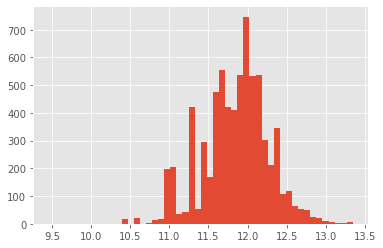

In [67]:
#use the log function to make the data normal
plt.hist(np.log(housing.SalePrice+1), bins = 50)

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


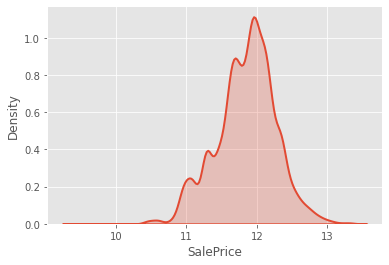

In [68]:
sns.distplot(np.log(housing.SalePrice+1), hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2})
plt.show()

In [69]:
np.log(housing["SalePrice"]).mean()

11.8446358522827

In [70]:
# Check the different types of foundations
#print(housing.Foundation.value_counts())
#sns.countplot(housing.Foundation)


7034
7034
7034
7034
7034
7034


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


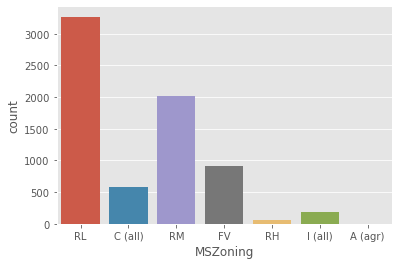

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


7034
7034
7034
7034


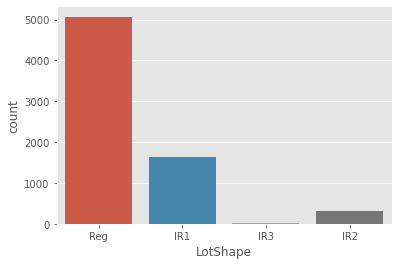

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


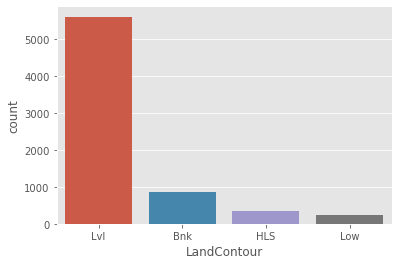

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


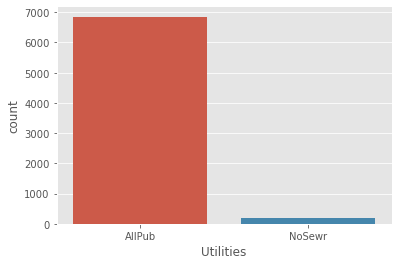

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


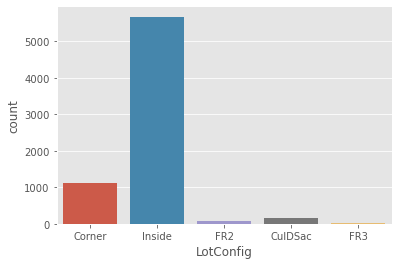

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


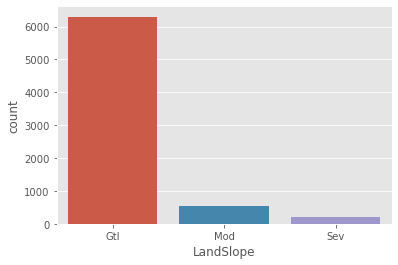

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


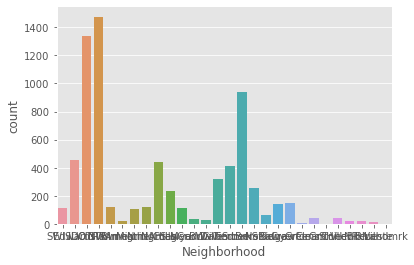

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


7034
7034


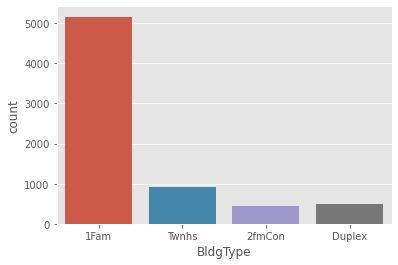

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


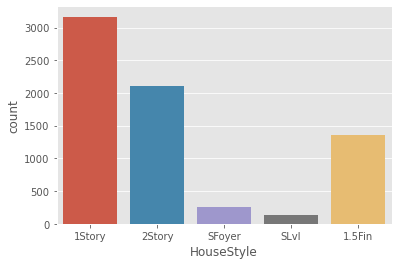

7034
7034
7034
7034
7034


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


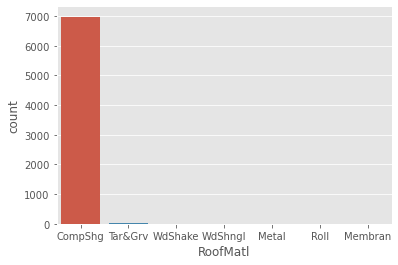

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


7034
7034
7034
7034
7034
7034
7034
7034
7034


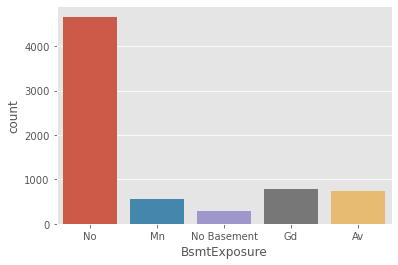

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


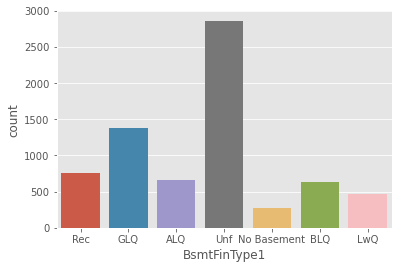

7034


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


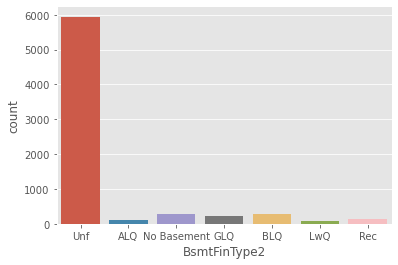

7034
7034
7034


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


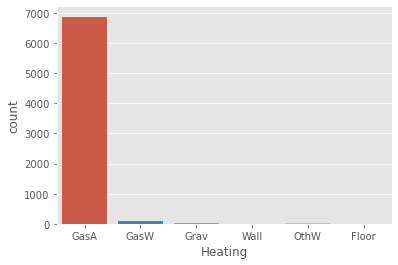

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


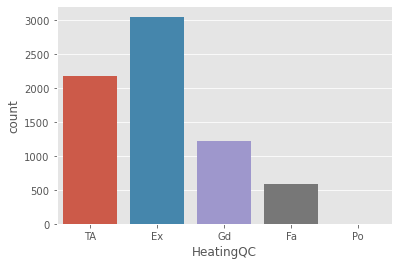

7034


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


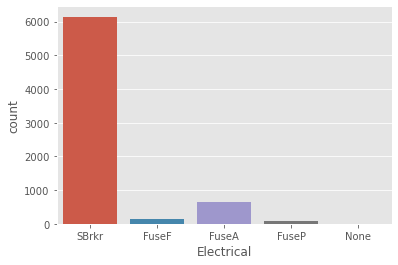

7034
7034
7034
7034
7034
7034
7034
7034
7034
7034
7034


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


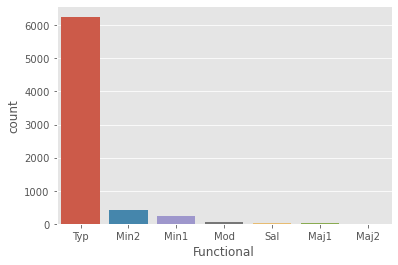

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


7034


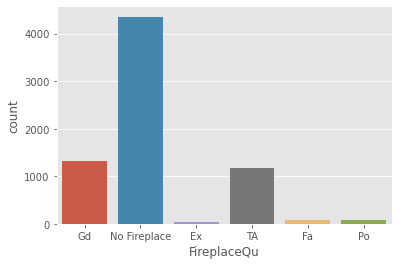

7034
7034


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


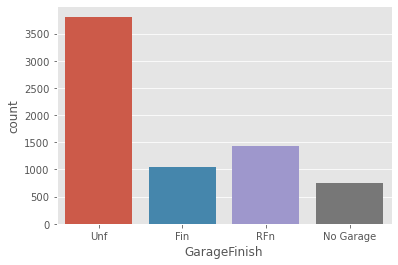

7034
7034
7034
7034
7034
7034
7034
7034
7034
7034
7034
7034


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


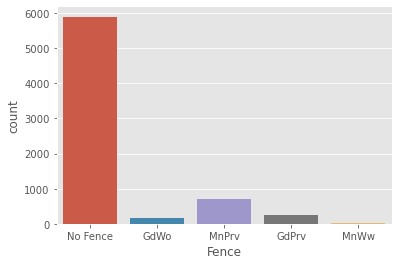

7034
7034
7034
7034
7034
7034
7034
7034
7034
7034


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


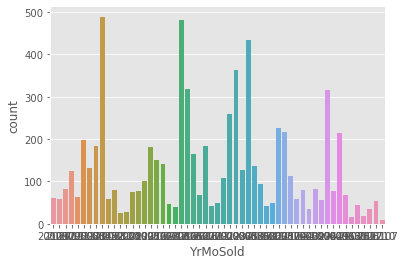

7034
7034
7034
7034
7034
7034


In [71]:
# Keep the numerical data to the left and categorical data to the right.
# Visualise the proportion of each categorical labels
categorical_data=[]
housing_new =pd.DataFrame()
#print(len(housing_new))
housing_new["SalePrice"]=housing["SalePrice"]
for ele in housing.columns:
    if np.dtype(housing[ele])== "int64" or np.dtype(housing[ele])=="float64":
        housing_new[ele] = housing[ele]
        print(len(housing_new))
    else:
        categorical_data.append(ele)
        sns.countplot(housing[ele])
    plt.show()

In [72]:
for name in categorical_data:
    print(name, ': number of values', len(housing[name].value_counts()))

MSZoning : number of values 7
LotShape : number of values 4
LandContour : number of values 4
Utilities : number of values 2
LotConfig : number of values 5
LandSlope : number of values 3
Neighborhood : number of values 28
BldgType : number of values 4
HouseStyle : number of values 5
RoofMatl : number of values 7
BsmtExposure : number of values 5
BsmtFinType1 : number of values 7
BsmtFinType2 : number of values 7
Heating : number of values 6
HeatingQC : number of values 5
Electrical : number of values 5
Functional : number of values 7
FireplaceQu : number of values 6
GarageFinish : number of values 4
Fence : number of values 5
YrMoSold : number of values 55


In [73]:
for ele in categorical_data:
    housing_new[ele] = housing[ele]

In [74]:
houisng = housing.drop(["YrMoSold"], axis=1)

In [75]:
# Get the dummies of each categorical Data.
for ele in categorical_data:
    # Converting type of columns to category
    housing_new=pd.get_dummies(housing_new, prefix="{}_".format(ele), 
                            columns=[ele], 
                            drop_first=True)
    

housing_new=housing_new.drop(["repeat","repeat1"], axis=1)

In [76]:
housing.Alley.value_counts()

-0.1    4199
 0.0    1575
 1.0    1260
Name: Alley, dtype: int64

# Fit the data 

--------------------------------------------------
R^2 for train set: 0.964528
R^2 for test set: 0.961486
--------------------------------------------------


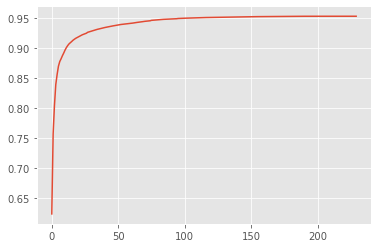

In [77]:
from sklearn.model_selection import train_test_split
from itertools import combinations
 
# Get all combinations of according to the best contributions in increasing the R^2
# The process creates a partail ording among the predictors where A rel B if A is Subset of B and R2A <=R2B
# The time complexity of this process is n* nC1=n**2 where n is the number of columns
fnlst =[]
cscores =[]
for ele in range(1,len(housing_new.columns),1):
    
    comb = combinations(housing_new.iloc[:,1:].columns.difference(fnlst), 1)

    lst=[]
    scores=[]
    
    # Print the obtained combinations
    for i in list(comb):
        ols = LinearRegression()
        X_train, X_test, y_train, y_test = train_test_split(housing_new[fnlst+list(i)], housing_new.iloc[:,0], test_size=0.5, random_state=0)
        #lst.append(list(i))
        ols.fit(X_train, y_train)
        lst.append(list(i))
        scores.append(ols.score(X_train, y_train))
    cscores.append(pd.Series(scores).max())
    fnlst =fnlst+lst[pd.Series(scores)[pd.Series(scores)==pd.Series(scores).max()].index[0]]





ols = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(housing_new[fnlst], np.log(housing_new["SalePrice"]), test_size=0.5, random_state=0)

ols.fit(X_train, y_train)
print('-'*50)

print("R^2 for train set: %f" %ols.score(X_train, y_train))
print("R^2 for test set: %f" %ols.score(X_test, y_test))

print('-'*50)



plt.plot(range(len(cscores)), cscores)